<a href="https://colab.research.google.com/github/Kakumanu-Harshitha/Face-Recognition/blob/main/Face_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model Description:
This face recognition model is designed to identify individuals based on facial images. It employs a Siamese network architecture, which is particularly effective for tasks involving similarity comparison between pairs of inputs. The model is trained to distinguish between the facial features of different individuals and is capable of predicting the identity of a person from a given image.

# 1.Import Libtaries

In [ ]:
import numpy as np
import cv2
import dlib
import matplotlib.pyplot as plt
import tensorflow as tf

# 2. Detect face in an image

Here we use Haar cascade classifiers to detect face in an image.The function here detect_face will take image as input and then detect face in that image after converting to gray image. Co-ordinates of fae in an image are stored in face variable. If more than one face is detected first face will be taken in to consideration.

In [ ]:
faceclassifier=cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
def detect_face(image):
  #image=cv2.imread(image)
  gray=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
  faces=faceclassifier.detectMultiScale(gray,1.3,5)
  if faces is ():
    print("No faces found")
  if len(faces)>0:
    (x, y, w, h) = faces[0]
    face = image[y:y+h, x:x+w]
    face=cv2.resize(face,(128,128))
    return face


<>:6: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:6: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-2-10ac3c2da3c1>:6: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if faces is ():


# 3. Make dataset to train images
Make a dataset with lables and face co-ordinates in that image using detect_face function.Ensure that face co-ordinates and approprite labels must be in same order.Here we want to train 5 persons to our model and we use just 2 images for every person.

In [ ]:
face_images=[]
labels=["Abdul Kalam","Virat Kohli","Sachin Tendulkar","Vivekananda"," Sachin Tendulkar","Vivekananda","Virat Kohli","Abdul Kalam"]
def faces(image_path):
  image=cv2.imread(image_path)
  face_image=detect_face(image)
  if face_image is not None:
    face_images.append(face_image)

faces("/content/abdul kalam 1.jpg")
faces("/content/virat kohli 1.jpg")
faces("/content/sachin-tendulkar 1.jpg")
faces("/content/vivekananda 1.jpg")
faces("/content/sachin-tendulkar 2.jpg")
faces("/content/vivekananda 2.jpg")
faces("/content/virat kohli  2.jpg")
faces("/content/Abdul Kalam2.jpg")


# 4. Create pairs to train the model
Here we use siamese network for face recognition. So that as per siamese network if 2 images are same(positive) then it will be labeled as 1. If 2 images are different(negative) then labeled as 0. We make a list so that every image will paired up with another image so that the list will consists of pairs of images. The targets will be 1 or 0 based on pairs.

In [ ]:
import numpy as np
def create_pairs(face_images, labels):
    pairs = []
    targets = []
    if len(face_images) != len(labels):
        print(f"Error: Mismatch between number of face images ({len(face_images)}) and labels ({len(labels)})")
        return None, None

    # Create positive pairs (same person)
    for i in range(len(face_images)):
        for j in range(i+1, len(face_images)):
            if labels[i] == labels[j]:  # Positive pair (same label)
                pairs.append([face_images[i], face_images[j]])
                targets.append(1)
            else:  # Negative pair (different label)
                pairs.append([face_images[i], face_images[j]])
                targets.append(0)

    return np.array(pairs), np.array(targets)

pairs, targets = create_pairs(face_images, labels)




# 5.Build a model
The siamese network will having same architecture for both the images with same weights and back propagation. Firstly there will be a feature extraction for every image in image pair.Then euclidean distance will be caluculated for both images in image pair.

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K

# Function to create the embedding model
def create_base_network(input_shape):
    input = Input(shape=input_shape)

    # Simple CNN for feature extraction
    x = Conv2D(64, (3, 3), activation='relu')(input)
    x = MaxPooling2D()(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D()(x)
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    return Model(input, x)

# Siamese Network - input_shape = (128, 128, 3)
input_shape = (128, 128, 3)
base_network = create_base_network(input_shape)

input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

# Create embeddings for both inputs
embedding_a = base_network(input_a)
embedding_b = base_network(input_b)

# Distance calculation (Euclidean distance)
def euclidean_distance(vectors):
    (feat_a, feat_b) = vectors
    sum_squared = K.sum(K.square(feat_a - feat_b), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_squared, K.epsilon()))

# Lambda layer to calculate distance
distance = Lambda(euclidean_distance)([embedding_a, embedding_b])

# Create final model
model = Model(inputs=[input_a, input_b], outputs=distance)


In [ ]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_2             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional (Functional)   │ (None, 256)            │     29,567,104 │ input_layer_1[0][0],   │
│                           │                        │                │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 1)              │              0 │ functional[0][0],      │
│                           │                        │                │ functional[1][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 29,567,104 (112.79 MB)

 Trainable params: 29,567,104 (112.79 MB)

 Non-trainable params: 0 (0.00 B)

Then model will be compiled with contrastive loss and adam optimizer with a learning rate of 0.0001. Then the model will be fitted in to pairs and their targets.

In [ ]:

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

# Define contrastive loss
def contrastive_loss(y_true, y_pred):
    margin = 1.0
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)

# Compile model
model.compile(loss=contrastive_loss, optimizer=Adam(learning_rate=0.0001))

# Train the model
model.fit([pairs[:, 0], pairs[:, 1]], targets, batch_size=16, epochs=30)


Epoch 1/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - loss: 2715.5645
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - loss: 13123.7920
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - loss: 850.9645
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - loss: 381.6741
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - loss: 425.8859
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - loss: 96.1304
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - loss: 31.2849
Epoch 8/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - loss: 10.0678
Epoch 9/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - loss: 30.1467
Epoch 10/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - loss: 71.4922
Epoch 11/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - loss: 72.6178
Epoch 12/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - loss: 23.8832
Epoch 13/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - loss: 27.2301
Epoch 14/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - loss: 5.5206
Epoch 15/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - loss: 11.9886
Epoch 16/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 2

# 6. Prediction of image
When an image is sent to recognize face from trained persons model will predict based on euclidean distance for every image on which model was trained. Based on minimum euclidean distance the model will finalize the recognized person name.

In [ ]:

def predict(image_path):
    # Detect face
    image=cv2.imread(image_path)
    face = detect_face(image)
    if face is None:
        return "No face detected"

    face = np.expand_dims(face, axis=0)

    min_dist = float('inf')
    identity = None

    # Compare with stored embeddings
    for i, stored_face in enumerate(face_images):
        stored_face = np.expand_dims(stored_face, axis=0)
        dist = model.predict([face, stored_face])[0][0]

        if dist < min_dist:
            min_dist = dist
            identity = labels[i]
    plt.imshow(image)
    plt.text(x=125, y=0, s=identity, fontsize=12, color='red', ha='center', va='center')
    plt.show()
    print(min_dist)

    return identity


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


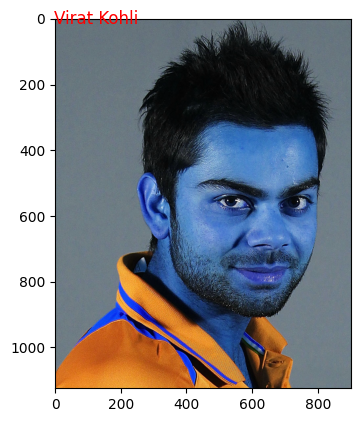

6.3918753


'Virat Kohli'

In [ ]:
predict("/content/virat kohli 3.jpg")

Here the model predicts that the face in an image is Virat Kohli with a min_ distance of 6.3918753
